# Web Scraping with Beautiful Soup

## Why Do We Need To Scrape At All?

To perform practical approaches to data science with text, we need...**text**. Some text is prepared for computational analysis and publicly available in digital libraries. We can easily get novels in the public domain as .txt files, for example, from [Project Gutenberg](https://www.gutenberg.org/). Or we can work with text from HathiTrust's vast collections through the [HathiTrust Research Center](https://analytics.hathitrust.org/). 

If we want to work with text from popular culture and the internet--and we do!--we often need to scrape the web. And in order to scrape the web, we need to learn a little bit about HTML. So that's where we'll be starting today.

### Inspecting HTML's anatomy with Developer Tools

Thanks to Alison Parrish, we have a very simple example of HTML to begin with. It is about kittens. [Here's the rendered version](http://static.decontextualize.com/kittens.html), and [here's the HTML source code](https://raw.githubusercontent.com/ledeprogram/courses/master/databases/data/kittens.html).

First we're going to use Developer Tools in Chrome to take a look at how `kittens.html` is organized. Click on the "rendered version" link above. In Chrome, ctrl-click (or right click) anywhere on the page and select "Inspect Element." This will open Chrome's Developer Tools. Your screen should look (something) like this:

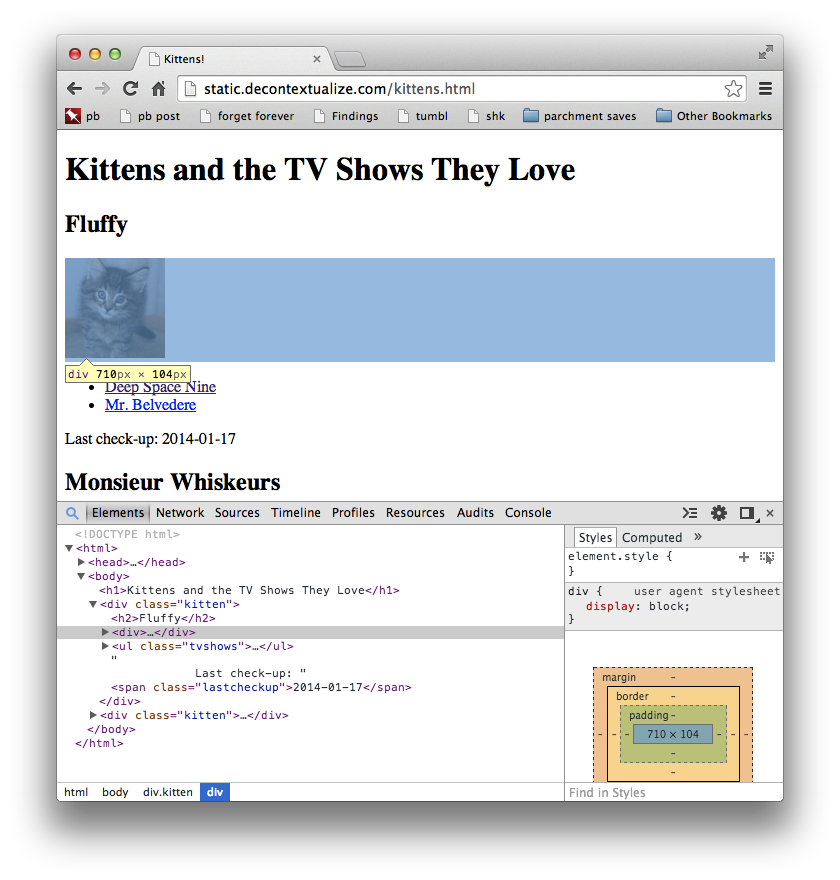

In the upper panel, you see the web page you're inspecting. In the lower panel, you see a version of the HTML source code, with little arrows next to some of the lines. (The little arrows allow you to collapse parts of the HTML source that are hierarchically related.) As you move your mouse over the elements in the top panel, different parts of the source code will be highlighted. Chrome is showing you which parts of the source code are causing which parts of the page to show up. Pretty nice!

Also note that this relationship works in reverse: you can move your mouse over some part of the source code in the lower panel, which will highlight in the top panel what that source code corresponds to on the page. We'll be using this later to visually identify the parts of the page that are interesting to us, so we can write code that extracts the contents of those parts automatically.

### Characterizing the structure of kittens

Let's go a little deeper down the HTML wormhole and take a look at the source code of kittens.html.

It looks like:

	<!doctype html>
	<html>
	  <head>
	    <title>Kittens!</title>
	  </head>
	  <body>
	    <h1>Kittens and the TV Shows They Love</h1>
	    <div class="kitten">
	      <h2>Fluffy</h2>
	      <div><img src="http://placekitten.com/100/100"></div>
	      <ul class="tvshows">
	        <li><a href="http://www.imdb.com/title/tt0106145/">Deep Space Nine</a></li>
	        <li><a href="http://www.imdb.com/title/tt0088576/">Mr. Belvedere</a></li>
	      </ul>
	      Last check-up: <span class="lastcheckup">2014-01-17</span>
	    </div>
	    <div class="kitten">
	      <h2>Monsieur Whiskeurs</h2>
	      <div><img src="http://placekitten.com/150/100"></div>
	      <ul class="tvshows">
	        <li><a href="http://www.imdb.com/title/tt0106179/">The X-Files</a></li>
	        <li><a href="http://www.imdb.com/title/tt0098800/">Fresh Prince</a></li>
	      </ul>
	      Last check-up: <span class="lastcheckup">2013-11-02</span>
	    </div>
	  </body>
	</html>

This is pretty well organized HTML, but if you don't know how to read HTML, it will still look like a big jumble. 





> **EXERCISE:** Some HTML questions:
>
> * What's the parent tag of `<a href="http://www.imdb.com/title/tt0088576/">Mr. Belvedere</a>`? 
> * Both `<div class="kitten">` tags share a parent tag---what is it? What attributes are present on both `<img>` tags?

### Scraping kittens with Beautiful Soup

We've examined `kittens.html` a bit now. What we'd like to do is write some code that is going to extract information from the HTML, like "what is the last checkup date for each of these kittens?" or "what are Monsieur Whiskeur's favorite TV shows?" To do so, we need to *parse* the HTML, and create a representation of it in our program that we can manipulate with Python.

As mentioned earlier, HTML is hard to parse by hand. (Don't even try it. In particular, [don't parse HTML with regular expressions](http://stackoverflow.com/a/1732454).)

[Beautiful Soup](http://www.crummy.com/software/BeautifulSoup/) is a Python library that parses HTML (even if it's poorly formatted) and allows us to extract and manipulate its contents. More specifically, it gives us some Python objects that we can call methods on to poke at the data contained therein. So instead of working with strings and bytes, we can work with Python objects, methods and data structures.

Note that Beautiful Soup only *parses* HTML. It's still left to us to actually *get* the HTML from somewhere. In most cases, we'll want to download the HTML directly from the actual web. For that, we'll use the `get` method from the Python library `requests` ([link](https://2.python-requests.org/en/master/)), which, if you were paying attention to the previous homework, you'll observe that we've used once before.

But first, let's import these two libraries:

In [ ]:
# import our libraries (which, if you're curious, I preinstalled for our class on JupyterHub)
from bs4 import BeautifulSoup
import requests 

If it worked, you won't get an error message.

To begin, let's use the "get" method to make an http request (the eponymous "requests") to get the contents of kittens.html.

In [ ]:
response = requests.get("http://static.decontextualize.com/kittens.html") 

Note that "response" is a Python object, and not plain text.

Also note that the "get" method makes things easy by guessing at the document's character encoding, so you don't need to worry about it--at least for the moment. (We'll talk more about encoding next class).

Now let's create a string with the contents of the web page in text format we use the "text" method for this.

In [ ]:
html_str = response.text
html_str # a nice shortcut: if you finish a cell with a variable, Colab will just display that variable 
         # you don't need a print statement!

That looks like a mess but it's apparent that we've obtained the data as desired.

Now we need to create a BeautifulSoup object from that data. 

To make a BeautifulSoup document, we call `BeautifulSoup()` with two parameters: the `html_str` from our HTTP request and [the kind of parser](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#specifying-the-parser-to-use) that we want to use, which will always be `"html.parser"` for our purposes.

It looks like this:

In [ ]:
document = BeautifulSoup(html_str, "html.parser")

And now let's see what we've got:

In [ ]:
document

And voila! 

This object, which I've I've assigned to the variable `document`, supports a number of interesting methods that allow us to dig into the contents of the HTML. 

Primarily what we'll be working with are `Tag` objects and `ResultSet` objects, which are essentially just lists of `Tag` objects.

### Finding a tag

As we've previously discussed, HTML documents are composed of tags. To represent this, Beautiful Soup has a type of value that represents tags. We can use the `.find()` method of the `BeautifulSoup` object to find a tag that matches a particular tag name. For example:

In [ ]:
h1_tag = document.find('h1')

h1_tag


A `Tag` object has several interesting attributes and methods. The `string` attribute of a `Tag` object, for example, returns a string representing that tag's contents:

In [ ]:
h1_tag.string

> **EXERCISE:** How would you find an HTML element that contains an image? (Hint: the HTML image tag is "img")

In [ ]:
## your code here





### Two things you might have noticed

**Thing 1:** You may have tried to view the text associated with the image--or maybe you didn't--but in any case, it doesn't work. This is because the location of the image is considered an *attribute* of the `<img>` tag, rather than simply being enclosed within it. 

Thankfully, BeautifulSoup makes it (relatively) easy to access the attributes of a tag by treating it as a dictionary. 

**NOTE FOR FOLKS USING PYTHON FOR THE FIRST TIME IN THIS COURSE:**

Unlike R, which (I think) just has lists, Python has two data types that store values: lists which are ordered, and store only one value, and dictionaries-- what I'm talking about here-- that store UNORDERED sets of values in key:value pairs. 

We'll learn more about dictionaries in the next class. For now, what you need to know is that, to print out the `src` attribute of the first `<img>` tag in the document, you would write:

In [ ]:
img['src']

More generally, dictionaries use this square-bracket index style of syntax, with the name of the attribute whose value you want typed as a string inside the brackets. 

For more on dictionaries, see [this notebook](dictionaries-sets-tuples.ipynb).

**Thing 2:** A second thing you might have noticed that there is more than one `<img>` tag in `kittens.html`! If more than one tag matches the name you pass to `.find()`, it returns only the *first* matching tag. (A better name for `.find()` might be `find_first`.) Which leads us to...

### Finding multiple tags

It's very often the case that we want to find not just one tag that matches particular criteria, but ALL tags matching those criteria. For that, we use the `.find_all()` method of the `BeautifulSoup` object. For example, to find all `h2` tags in the document:

In [ ]:
h2_tags = document.find_all('h2')

h2_tags

But what if we want to see just the text of these headers?

To do so, we're going to need to use a loop.

We're going to use some 'for' loop syntax that's very common in Python:

In [ ]:
for tag in h2_tags:
    print(tag.string) 

This conventiently gives you a variable, `tag`, that updates with the appropriate value each time you iterate. 

(For more on loops and counting, see [this optional notebook](extra-counting.ipynb)). 

### .string vs. get_text()

While the .string attribute is the officially documented way to extract the text associated with a particular tag, there is a "greedier" method, `.get_text()`, that will return *either* the text in a tag *or* all of the text (tags included) if the text is not in a tag.

In this particular case, both .string and .get_text() return the same output. But in some cases you will need to use .get_text() in order to extract the text you are looking for. It's good to know about both. 

In [ ]:
for tag in h2_tags:
    print(tag.get_text()) 

### Searching for specific attributes

Both the `.find()` and `.find_all()` methods can search not just for tags with particular names, but also for tags that have particular attributes. For that, we use the `attrs` keyword argument, giving it a dictionary that associates attribute names as keys and the desired attribute value as values. For example, to find all `span` tags with a `class` attribute of `lastcheckup`:

In [ ]:
checkup_tags = document.find_all('span', attrs={'class': 'lastcheckup'})

checkup_tags

> **EXERCISE**: Can you create a list of the dates of each of the checkups using a 'for' loop and the `.get_text()` method?

> Indented block



In [ ]:
# your code here






### List comprehension with tags! 

At the end of last class, I introduced a confusing yet useful (and therefore ubituitous) syntax that we will see in our code as we proceed in this course, called a list comprehension. 

For review: *list comprehension* helps with a very common task in both data analysis and programming more generally: when you want to apply an operation to every item in a list (e.g., scaling the numbers in a list by a fixed factor), or creating a copy of a list with only those items that match a particular criterion (e.g., eliminating values that fall below a certain threshold). 

A list comprehension has a few parts, arranged like so:

> `[` *predicate expression* `for` *temporary variable name* `in` *source list* `if` *membership expression* `]`

Working through these parts one by one, they are: 

* a source list, or the list whose values will be transformed or filtered;
* a predicate expression, to be evaluated for every item in the list;
* (optionally) a membership expression that determines whether or not an item in the source list will be included in the result of evaluating the list comprehension, based on whether the expression evaluates to True or False; and
* a temporary variable name by which each value from the source list will be known in the predicate expression and membership expression.

The words for, in, and if are a part of the syntax of the expression. They don't mean anything in particular (and in fact, they do completely different things in other parts of the Python language). You just have to spell them right and put them in the right place in order for the list comprehension to work.

You can see more examples of this in action [here](class3_lists.ipynb).

It's also OK if you never use list comprehension in your code ever again. But for now, I'd like you to try rewriting your for loop, up above, in list comprehension format




> **EXERCISE**: Can you create a list of the dates of each of the checkups using a list comprehension?

Hint: 

1.   The source list is `checkup_tags`
2.   The temporary variable name is `tag`
3.   The predicate expression is `.get_text()`




In [ ]:
# your code here




### Finding tags within tags

Beautiful Soup's `.find()` and `.find_all()` methods are actually more powerful than I've let on thus far. [Check out the details in the official Beautiful Soup documentation](http://www.crummy.com/software/BeautifulSoup/bs4/doc/#find-all) to learn about all that BeautifulSoup can do. 

But for now, let's give ourselves a challenge: 

Let's say that we wanted to print out a list of the name of each kitten, along with a list of the names of that kitten's favorite TV shows. In other words, we want to print out something that looks like this:

    Fluffy: Deep Space Nine, Mr. Belvedere
    Monsieur Whiskeurs: The X-Files, Fresh Prince
    
In order to do this, we need to find *not just* tags with particular names, but tags with *particular hierarchical relationships* with other tags. I.e., we need to identify all of the kittens, and then find the shows that belong to that kitten. This kind of search is made easy by the fact that you can use `.find()` and `.find_all()` methods not just on the entire document, but on *individual tags*. When you use these methods on tags, they search for matching tags that are specifically *children of* the tag that you call them on.

Let's refer back to the HTML of our kittens doc.

In [ ]:
document

So, we can see that information about individual kittens is grouped together under `<div>` tags with a `class` attribute of `kitten`. 

To find a list of all `<div>` tags with `class` set to `kitten`, what might we do?

In [ ]:
kitten_tags = # complete w/ code



But we're not done yet! We still need to loop over that list of tags and find both the names and the shows associated with each kitten, Let's start with the first one of those-- the names: 

To loop through the list of kitten tags to find each of their names, how might we do that?

In [ ]:
for kitten_tag in kitten_tags:
    # rest of loop here

Now, we'll go one more step. Looping over all of the kitten tags, we'll find not just the `<h2>` tag with the kitten's name, but *all* `<a>` tags (which contain the names of the TV shows that we were looking for). How might we do that?

In [ ]:
for kitten_tag in kitten_tags:
    h2_tag = kitten_tag.find('h2')
    print(h2_tag.string)
    # new stuff here 

> **THE CHALLENGE:** Using your newfound string manipulation skills from last night's homework, can you modify this list so that the names and shows are printed out in the following format:
>

    Fluffy: Deep Space Nine, Mr. Belvedere
    Monsieur Whiskeurs: The X-Files, Fresh Prince


In [ ]:
for kitten_tag in kitten_tags:
    h2_tag = kitten_tag.find('h2')
    a_tags = kitten_tag.find_all('a')
    
    # lots of ways to do this...

### A final helpful method for finding sibling tags

Often, the tags we're looking for don't have a distinguishing characteristic, like a `class` attribute, that allows us to find them using `.find()` and `.find_all()`, and the tags also aren't in a parent-child relationship. This can be tricky! Take the following HTML snippet, for example:    

cheese_html = """
<h2>Camembert</h2>
<p>A soft cheese made in the Camembert region of France.</p>

<h2>Cheddar</h2>
<p>A yellow cheese made in the Cheddar region of... France, probably, idk whatevs.</p>
"""

If our task was to create a list of the name of the cheese followed by the description that follows in the `<p>` tag directly afterward, we'd be out of luck. Fortunately, Beautiful Soup has a `.find_next_sibling()` method, which allows us to search for the next tag that is a *sibling* of the tag you're calling it on (i.e., the two tags share a parent), that also matches particular criteria. So, for example, to accomplish the task outlined above:

In [ ]:
document = BeautifulSoup(cheese_html, "html.parser")
cheese_dict = {}
for h2_tag in document.find_all('h2'):
    cheese_name = h2_tag.string
    cheese_desc_tag = h2_tag.find_next_sibling('p')
    cheese_dict[cheese_name] = cheese_desc_tag.string

cheese_dict

You now know most of what you need to know to scrape web pages effectively. Good job!

But before you're done, we should talk about what to do when things go wrong.

### When things go wrong with Beautiful Soup

A number of things might go wrong with Beautiful Soup. You might, for example, search for a tag that doesn't exist in the document:

In [ ]:
footer_tag = document.find("footer")

Beautiful Soup doesn't return an error if it can't find the tag you want. Instead, it returns `None`:

In [ ]:
type(footer_tag)

If you try to call a method on the object that Beautiful Soup returned anyway, you might end up with an error like this:

In [ ]:
footer_tag.find("p")

You might also inadvertently try to get an attribute of a tag that wasn't actually found. You'll get a similar error in that case:

In [ ]:
footer_tag['title']

Whenever you see something like `TypeError: 'NoneType' object is not subscriptable`, it's a good idea to check to see whether your method calls are indeed finding the thing you were looking for.

However, the `.find_all()` method will return an empty list if it doesn't find any of the tags you wanted:

In [ ]:
footer_tags = document.find_all("footer")
print(footer_tags)

If you attempt to access one of the elements of this regardless...

In [ ]:
print(footer_tags[0].string)

...you'll get an `IndexError`.

## Further reading

* [Chapter 11](https://automatetheboringstuff.com/chapter11/) from Al Sweigart's [Automate the Boring Stuff with Python](https://automatetheboringstuff.com/) is another good take on this material (and discusses a wider range of techniques).
* [The official Beautiful Soup documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) provides a systematic walkthrough of the library's functionality. If you find yourself thinking, "it really should be easy to do the thing that I want to do, why isn't it easier?" then check the documentation! Leonard's probably already thought of a way to make it easier and implemented a feature in the code to help you out.
* Beautiful Soup is the best scraping library out there for quick jobs, but if you have a larger site that you need to scrape, you might look into [Scrapy](http://scrapy.org/), which bundles a good parser with a framework for writing web "spiders" (i.e., programs that parse web pages and follow the links found there, in order to make a catalog of an entire web site, not just a single web page).

# Acknowledgments

*Version 1 of this notebook was written by Lauren Klein in 2019, based on lessons by [Alison Parrish](http://www.decontextualize.com/) and [Jinho Choi](https://github.com/emory-courses/data-science/blob/master/course/data_aggregation/data_aggregation.ipynb). The 2022 version has been revised to incorporate additional materials from [Dan Sinykin](http://www.dansinykin.com/) and [Melanie Walsh](https://melaniewalsh.org/intro-ca-jupyter-book/).* 

